In [7]:
import pandas as pd
import numpy as np
import pylab as plt

In [8]:
import glob
CSV=glob.glob('../*summary*csv')
CSV1=glob.glob('../*csv')


In [12]:
CSV

['../salmonella.year_summary.csv',
 '../rsv.year_summary.csv',
 '../pox.year_summary.csv',
 '../hcov.year_summary.csv',
 '../flu.year_summary.csv',
 '../ecoli.year_summary.csv']

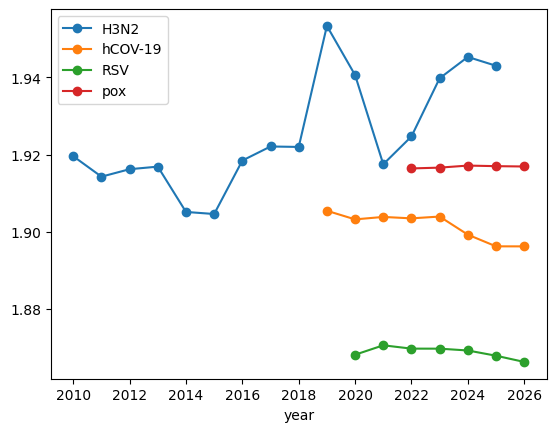

In [13]:
ax=pd.read_csv(CSV[4]).set_index('year')[['avg_bits_per_base_corrected']].plot(style='-o',
                                                                              label='H3N2')
pd.read_csv(CSV[3]).set_index('year')[['avg_bits_per_base_corrected']]\
                            .plot(ax=ax,style='-o',label='hCOV-19')
pd.read_csv(CSV[1]).set_index('year')[['avg_bits_per_base_corrected']]\
                            .plot(ax=ax,style='-o',label='RSV')
pd.read_csv(CSV[2]).set_index('year')[['avg_bits_per_base_corrected']]\
                            .plot(ax=ax,style='-o',label='pox')
plt.legend(['H3N2','hCOV-19','RSV','pox'])

In [45]:
sigma_corr=pd.read_csv( '../ecoli.per_assembly.csv').drop(['accession','file'],axis=1)\
                        .groupby('year').std().zlib_bytes_corrected

In [46]:
xf=pd.read_csv( '../ecoli.year_summary.csv')
xf['corrected'] = (2*0.85*xf.mean_zlib_bytes_corrected)/xf.mean_optimal_2bit_bytes
xf['sigma'] = sigma_corr.values
xf['ci_u'] = xf['corrected']+(2*0.92*(2*xf['sigma']/np.sqrt(xf.n_assemblies)))/xf.mean_optimal_2bit_bytes
xf['ci_l'] = xf['corrected']-(2*0.92*(2*xf['sigma']/np.sqrt(xf.n_assemblies)))/xf.mean_optimal_2bit_bytes
xf0=xf.copy()

In [47]:
sigma_corr=pd.read_csv( '../salmonella.per_assembly.csv').drop(['accession','file'],axis=1)\
                        .groupby('year').std().zlib_bytes_corrected
xf=pd.read_csv( '../salmonella.year_summary.csv')
xf['corrected'] = (2*0.85*xf.mean_zlib_bytes_corrected)/xf.mean_optimal_2bit_bytes
xf['sigma'] = sigma_corr.values
xf['ci_u'] = xf['corrected']+(2*0.91*(2*xf['sigma']/np.sqrt(xf.n_assemblies)))/xf.mean_optimal_2bit_bytes
xf['ci_l'] = xf['corrected']-(2*0.91*(2*xf['sigma']/np.sqrt(xf.n_assemblies)))/xf.mean_optimal_2bit_bytes

(2019.0, 2026.0)

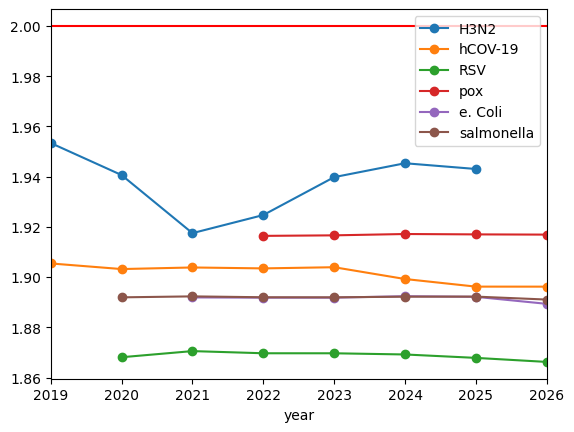

In [49]:




ax=pd.read_csv(CSV[4]).set_index('year')[['avg_bits_per_base_corrected']].plot(style='-o',
                                                                              label='H3N2')
pd.read_csv(CSV[3]).set_index('year')[['avg_bits_per_base_corrected']]\
                            .plot(ax=ax,style='-o',label='hCOV-19')
pd.read_csv(CSV[1]).set_index('year')[['avg_bits_per_base_corrected']]\
                            .plot(ax=ax,style='-o',label='RSV')
pd.read_csv(CSV[2]).set_index('year')[['avg_bits_per_base_corrected']]\
                            .plot(ax=ax,style='-o',label='pox')
xf0.set_index('year').corrected.plot(ax=ax,style='-o',label='ecoli')
xf.set_index('year').corrected.plot(ax=ax,style='-o',label='salmonella')

plt.plot([2010,2026],[2,2],'-r')
plt.legend(['H3N2','hCOV-19','RSV','pox','e. Coli','salmonella'])
#plt.gca().set_ylim(1.8,2.01)
plt.gca().set_xlim(2019,2026)


In [25]:
wf=pd.read_csv(CSV[2])[['mean_seq_len','avg_bits_per_base','avg_bits_per_base_corrected']]

<Axes: xlabel='llen', ylabel='ratio'>

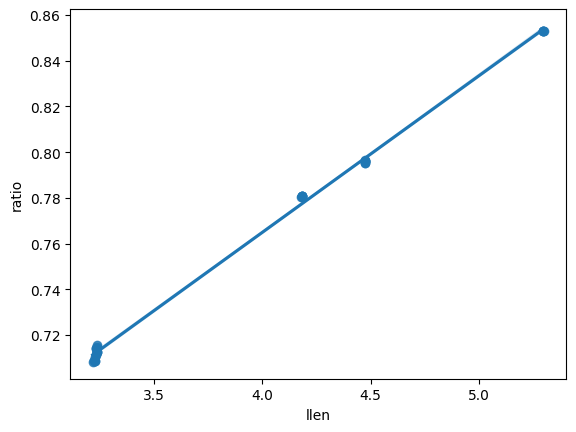

In [40]:
wwf=[]
for i in [1,2,3,4]:
    wf=pd.read_csv(CSV[i])[['mean_seq_len','avg_bits_per_base','avg_bits_per_base_corrected']]
    wf['ratio'] = wf.avg_bits_per_base_corrected/wf.avg_bits_per_base
    wwf.append(wf[['mean_seq_len','ratio']])
wf=pd.concat(wwf)
wf['llen']=np.log10(wf.mean_seq_len)
import seaborn as sns
sns.regplot(data=wf,x='llen',y='ratio')

In [43]:
np.log10(5.226408e6)

np.float64(6.718203309951616)

In [50]:
import numpy as np
import statsmodels.api as sm

def fit_ratio_model(df):
    """
    Fit linear model:
        ratio ~ log10(mean_seq_len)
    Returns fitted model object.
    """
    X = np.log10(df["mean_seq_len"].values)
    X = sm.add_constant(X)  # adds intercept
    y = df["ratio"].values
    
    model = sm.OLS(y, X).fit()
    return model


def make_ratio_predictor(model):
    """
    Given a fitted model, return a function that
    predicts ratio from new mean_seq_len values.
    """
    beta0, beta1 = model.params
    
    def predict(mean_seq_len):
        mean_seq_len = np.asarray(mean_seq_len)
        return beta0 + beta1 * np.log10(mean_seq_len)
    
    return predict


In [52]:
model = fit_ratio_model(wf)
predict_ratio = make_ratio_predictor(model)

# Example predictions
new_lengths = np.array([1e3, 1e4, 5e6])
predicted_ratios = predict_ratio(new_lengths)
print(predicted_ratios)

[0.69623586 0.76487559 0.95013217]


In [103]:
import numpy as np
from scipy.optimize import curve_fit

def sat_model(x, a, b, c):
    lx = np.log10(x)
    return a - b * np.exp(-c * lx)

def fit_saturating_model(df):
    x = df["mean_seq_len"].values
    y = df["ratio"].values
    
    # sensible initialization
    a0 = np.max(y)         # upper asymptote
    b0 = a0 - np.min(y)    # amplitude
    c0 = 5.5              # slope scale
    
    popt, _ = curve_fit(sat_model, x, y, p0=[a0, b0, c0], maxfev=10000)
    return popt

def make_ratio_predictor(params):
    def predict(mean_seq_len):
        return sat_model(np.asarray(mean_seq_len), *params)
    return predict
params = fit_saturating_model(wf)
predict_ratio = make_ratio_predictor(params)


/tmp/ipykernel_811777/4263122833.py:6: RuntimeWarning: overflow encountered in exp
  return a - b * np.exp(-c * lx)


In [106]:
sigma_corr=pd.read_csv( '../ecoli.per_assembly.csv').drop(['accession','file'],axis=1)\
                        .groupby('year').std().zlib_bytes_corrected
xf=pd.read_csv( '../ecoli.year_summary.csv')
xf['corrected'] = (predict_ratio(xf.mean_n_bases.values)*2*xf.mean_zlib_bytes_corrected)/xf.mean_optimal_2bit_bytes
xf['sigma'] = sigma_corr.values
xf['ci_u'] = xf['corrected']+(2*predict_ratio(xf.mean_n_bases.values)*(2*xf['sigma']/np.sqrt(xf.n_assemblies)))/xf.mean_optimal_2bit_bytes
xf['ci_l'] = xf['corrected']-(2*predict_ratio(xf.mean_n_bases.values)*(2*xf['sigma']/np.sqrt(xf.n_assemblies)))/xf.mean_optimal_2bit_bytes
xf0=xf.copy()

In [107]:
xf0

,year,n_assemblies,mean_n_bases,mean_optimal_2bit_bytes,mean_zlib_bytes,mean_zlib_bytes_corrected,corrected,sigma,ci_u,ci_l
0,2021,1361,5.226408e+06,1.306602e+06,1.462329e+06,1.454088e+06,1.898716,77096.269533,1.904174,1.893258
1,2022,1212,5.107483e+06,1.276871e+06,1.429169e+06,1.420928e+06,1.898619,76112.647418,1.904462,1.892777
2,2023,1620,5.121282e+06,1.280321e+06,1.433007e+06,1.424767e+06,1.898618,93888.989319,1.904835,1.892401
3,2024,2319,5.085716e+06,1.271429e+06,1.423550e+06,1.415309e+06,1.899205,195180.163451,1.910083,1.888327
4,2025,1973,5.178841e+06,1.294710e+06,1.449277e+06,1.441036e+06,1.898956,123701.960043,1.906296,1.891616
5,2026,300,5.186162e+06,1.296541e+06,1.449184e+06,1.440944e+06,1.896154,68398.709421,1.906547,1.885761


In [108]:
sigma_corr=pd.read_csv( '../salmonella.per_assembly.csv').drop(['accession','file'],axis=1)\
                        .groupby('year').std().zlib_bytes_corrected
xf=pd.read_csv( '../salmonella.year_summary.csv')
xf['corrected'] = (predict_ratio(xf.mean_n_bases.values)*2*xf.mean_zlib_bytes_corrected)/xf.mean_optimal_2bit_bytes
xf['sigma'] = sigma_corr.values
xf['ci_u'] = xf['corrected']+(2*predict_ratio(xf.mean_n_bases.values)*(2*xf['sigma']/np.sqrt(xf.n_assemblies)))/xf.mean_optimal_2bit_bytes
xf['ci_l'] = xf['corrected']-(2*predict_ratio(xf.mean_n_bases.values)*(2*xf['sigma']/np.sqrt(xf.n_assemblies)))/xf.mean_optimal_2bit_bytes


(2019.0, 2026.0)

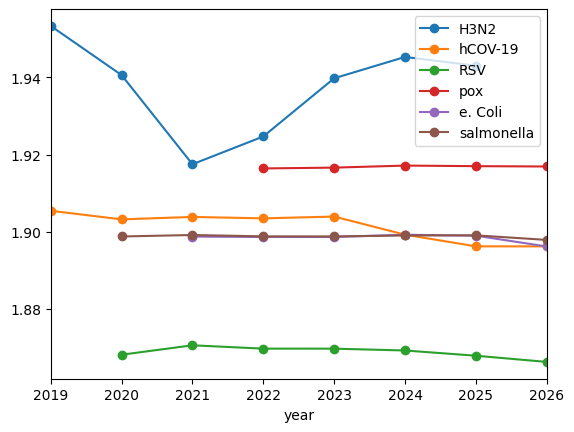

In [112]:



ax=pd.read_csv(CSV[4]).set_index('year')[['avg_bits_per_base_corrected']].plot(style='-o',
                                                                              label='H3N2')
pd.read_csv(CSV[3]).set_index('year')[['avg_bits_per_base_corrected']]\
                            .plot(ax=ax,style='-o',label='hCOV-19')
pd.read_csv(CSV[1]).set_index('year')[['avg_bits_per_base_corrected']]\
                            .plot(ax=ax,style='-o',label='RSV')
pd.read_csv(CSV[2]).set_index('year')[['avg_bits_per_base_corrected']]\
                            .plot(ax=ax,style='-o',label='pox')
xf0.set_index('year').corrected.plot(ax=ax,style='-o',label='ecoli')
xf.set_index('year').corrected.plot(ax=ax,style='-o',label='salmonella')

#plt.plot([2010,2026],[2,2],'-r')
plt.legend(['H3N2','hCOV-19','RSV','pox','e. Coli','salmonella'])
#plt.gca().set_ylim(1.8,2.01)
plt.gca().set_xlim(2019,2026)


In [145]:
pd.read_csv(CSV[1])

,year,count,mean,std,sem,ci_low,ci_high,n_seqs,mean_seq_len,avg_uncompressed_bytes,avg_zlib_bytes,avg_compression_ratio,avg_bytes_per_base,avg_bits_per_base,avg_ratio_vs_2bit,avg_excess_bits_per_base,avg_overhead_bits_hat,avg_bits_per_base_corrected
0,2020,740,1.868076,0.005403,0.000199,1.867687,1.868465,740,15165.962162,15165.962162,4536.958108,0.299155,0.299155,2.393238,1.196523,0.393238,7964.524324,1.868076
1,2021,2327,1.870518,0.007200,0.000149,1.870225,1.870811,2327,15197.315857,15197.315857,4551.126343,0.299469,0.299469,2.395755,1.197759,0.395755,7982.169317,1.870518
2,2022,3098,1.869656,0.014999,0.000269,1.869127,1.870184,3098,15202.765655,15202.765655,4550.766624,0.299338,0.299338,2.394703,1.197235,0.394786,7982.163977,1.869656
3,2023,4314,1.869648,0.007986,0.000122,1.869409,1.869886,4314,15197.076959,15197.076959,4548.913537,0.299328,0.299328,2.394624,1.197197,0.394624,7978.086231,1.869648
4,2024,5043,1.869175,0.031304,0.000441,1.868311,1.870039,5043,15193.332937,15193.332937,4546.819948,0.299265,0.299265,2.394119,1.196947,0.394591,7975.631172,1.869175
5,2025,3357,1.867817,0.008731,0.000151,1.867522,1.868112,3357,15181.463807,15181.463807,4540.783140,0.299101,0.299101,2.392811,1.196291,0.392811,7970.151921,1.867817
6,2026,5,1.866208,0.009901,0.004428,1.857530,1.874886,5,15217.000000,15217.000000,4547.000000,0.298811,0.298811,2.390490,1.195135,0.390490,7978.000000,1.866208


In [146]:
ORG={1:'RSV',2:'Pox',3:'hCOV-19',4:'H3N2'}
df=pd.concat([pd.read_csv(CSV[i])[['year','count','ci_low','ci_high','avg_bits_per_base_corrected']].assign(organism=ORG[i]) for i in [1,2,3,4]])
    
df.dropna()

,year,count,ci_low,ci_high,avg_bits_per_base_corrected,organism
0,2020,740,1.867687,1.868465,1.868076,RSV
1,2021,2327,1.870225,1.870811,1.870518,RSV
2,2022,3098,1.869127,1.870184,1.869656,RSV
3,2023,4314,1.869409,1.869886,1.869648,RSV
4,2024,5043,1.868311,1.870039,1.869175,RSV
5,2025,3357,1.867522,1.868112,1.867817,RSV
6,2026,5,1.857530,1.874886,1.866208,RSV
0,2022,2026,1.916251,1.916548,1.916400,Pox
1,2023,369,1.916334,1.916884,1.916609,Pox
2,2024,367,1.916971,1.917309,1.917140,Pox


In [148]:
sigma_corr=pd.read_csv( '../salmonella.per_assembly.csv').drop(['accession','file'],axis=1)\
                        .groupby('year').std().zlib_bytes_corrected
xf=pd.read_csv( '../salmonella.year_summary.csv')
xf['corrected'] = (predict_ratio(xf.mean_n_bases.values)*2*xf.mean_zlib_bytes_corrected)/xf.mean_optimal_2bit_bytes
xf['sigma'] = sigma_corr.values
xf['ci_u'] = xf['corrected']+(2*predict_ratio(xf.mean_n_bases.values)*(2*xf['sigma']/np.sqrt(xf.n_assemblies)))/xf.mean_optimal_2bit_bytes
xf['ci_l'] = xf['corrected']-(2*predict_ratio(xf.mean_n_bases.values)*(2*xf['sigma']/np.sqrt(xf.n_assemblies)))/xf.mean_optimal_2bit_bytes

xf=xf[['year','n_assemblies','corrected','ci_u','ci_l']]
xf.columns=['year','count','avg_bits_per_base_corrected','ci_high','ci_low']
xf=xf.assign(organism='salmonella')


sigma_corr=pd.read_csv( '../ecoli.per_assembly.csv').drop(['accession','file'],axis=1)\
                        .groupby('year').std().zlib_bytes_corrected
xf1=pd.read_csv( '../ecoli.year_summary.csv')
xf1['corrected'] = (predict_ratio(xf1.mean_n_bases.values)*2*xf1.mean_zlib_bytes_corrected)/xf1.mean_optimal_2bit_bytes
xf1['sigma'] = sigma_corr.values
xf1['ci_u'] = xf1['corrected']+(2*predict_ratio(xf1.mean_n_bases.values)*(2*xf1['sigma']/np.sqrt(xf1.n_assemblies)))/xf1.mean_optimal_2bit_bytes
xf1['ci_l'] = xf1['corrected']-(2*predict_ratio(xf1.mean_n_bases.values)*(2*xf1['sigma']/np.sqrt(xf1.n_assemblies)))/xf1.mean_optimal_2bit_bytes

xf1=xf1[['year','n_assemblies','corrected','ci_u','ci_l']]
xf1.columns=['year','count','avg_bits_per_base_corrected','ci_high','ci_low']
xf1=xf1.assign(organism='ecoli')


In [149]:
df1=pd.concat([df,xf,xf1]).dropna()
df1.columns

Index(['year', 'count', 'ci_low', 'ci_high', 'avg_bits_per_base_corrected',
       'organism'],
      dtype='object')

<Axes: >

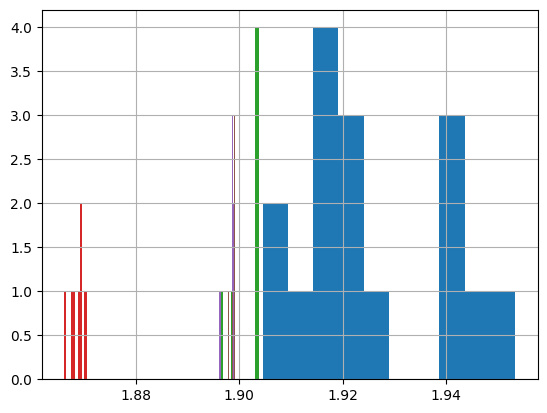

In [150]:
ax=df1[df1.organism=='H3N2'].avg_bits_per_base_corrected.hist()
df1[df1.organism=='RSV'].avg_bits_per_base_corrected.hist(ax=ax)
df1[df1.organism=='hCOV-19'].avg_bits_per_base_corrected.hist(ax=ax)
df1[df1.organism=='RSV'].avg_bits_per_base_corrected.hist(ax=ax)
df1[df1.organism=='ecoli'].avg_bits_per_base_corrected.hist(ax=ax)
df1[df1.organism=='salmonella'].avg_bits_per_base_corrected.hist(ax=ax)


<Axes: xlabel='year'>

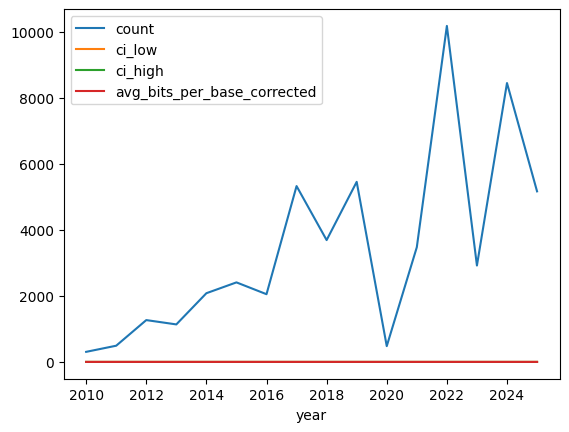

In [151]:
df1[df1.organism=='H3N2'].set_index('year').plot()

In [152]:
df1.to_csv('genomecompress.csv',index=None)